In [1]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [3]:
from tqdm.auto import tqdm

In [4]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

#from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

# Binary Synthetic Data

In [5]:
from kcmc.data_binary import evaluate_policy, generate_data, estimate_p_t

In [6]:
beta_e_x = np.asarray([0, .75, -.5, 0, -1])

def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1. - T) * e_x + T * (1. - e_x)

In [7]:
# Guessing kernel with approximate solution
Y, T, X, _, _, _ = generate_data(1000)
p_t = estimate_p_t(X, T)
_, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, toy_policy, lambd=1.5,
    hajek_const=True, tan_box_const=True, 
    return_w=True, normalize_p_t=True, 
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2

### Experiment of changing sensitivity parameter $\Lambda$ 

In [60]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        quantile_const=True,
    ),
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
}

grid_lambd = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [11]:
log_file='logs/policy_evaluation_synthetic_binary_changing_lambda.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_lambd))
for method_name, params in grid_methods.items():
    for lambd in grid_lambd:
        params['lambd'] = lambd
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic binary', 
            n_seeds=10, sample_size=500, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/44 [00:00<?, ?it/s]

In [61]:
df = pd.read_csv('logs/policy_evaluation_synthetic_binary_changing_lambda.csv')

In [62]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,synthetic binary,toy_policy,500,0,3.702457,3.724026,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
1,ZSB,synthetic binary,toy_policy,500,1,3.770768,3.796286,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
2,ZSB,synthetic binary,toy_policy,500,2,3.535814,3.557641,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
3,ZSB,synthetic binary,toy_policy,500,3,3.624325,3.640795,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False
4,ZSB,synthetic binary,toy_policy,500,4,3.664120,3.686011,200,1.01,0.01,...,False,True,total variation,True,False,False,False,True,False,False


In [63]:
# due to the numerical rounding, some of the original values are invalid indices
grid_lambd = df.lambd.unique()  

In [64]:
df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1586525/1363206736.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']


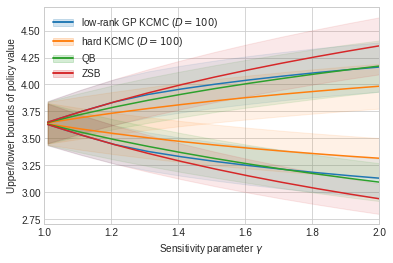

In [66]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB", "ZSB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    lower = np.array([values_mean.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    dupper = np.array([values_std.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    dlower = np.array([values_std.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    c = colors[method_name]
    upper_line = plt.plot(grid_lambd, upper, c=c)[0]
    lower_line = plt.plot(grid_lambd, lower, c=c)[0]
    upper_band = plt.fill_between(grid_lambd, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_lambd, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.savefig('logs/policy_evaluation_synthetic_binary_changing_lambda.pdf')

### Experiment of changing sample size

In [67]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        # D=n // 5,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        # D=n // 5,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        quantile_const=True,
    ),
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
}

grid_sample_size = [100 * i for i in range(1, 11)]

In [ ]:
log_file='logs/policy_evaluation_synthetic_binary_changing_sample_size.csv'

pbar = tqdm(total=len(grid_methods) * sum(n ** 2 for n in grid_sample_size))
for method_name, params in grid_methods.items():
    for n in grid_sample_size:
        params['D'] = n // 5
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic binary', 
            n_seeds=10, sample_size=n, log_info=method_name
        )
        pbar.update(n ** 2)
pbar.close()

In [69]:
df = pd.read_csv('logs/policy_evaluation_synthetic_binary_changing_sample_size.csv')

In [70]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,synthetic binary,toy_policy,100,0,3.663569,4.607054,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
1,ZSB,synthetic binary,toy_policy,100,1,3.335259,3.980575,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
2,ZSB,synthetic binary,toy_policy,100,2,2.288669,2.818702,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
3,ZSB,synthetic binary,toy_policy,100,3,3.151648,3.922349,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False
4,ZSB,synthetic binary,toy_policy,100,4,2.758201,3.418388,20,1.5,0.01,...,False,True,total variation,True,False,False,False,True,False,False


In [71]:
df_grouped = df.groupby(by=['log_info', 'sample_size'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1586525/2653174186.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'sample_size'])['lower_bound', 'upper_bound']


In [75]:
Y, T, X, _, _, _ = generate_data(100000)
p_t = estimate_p_t(X, T)
ground_truth = hajek(Y, T, X, p_t, toy_policy)

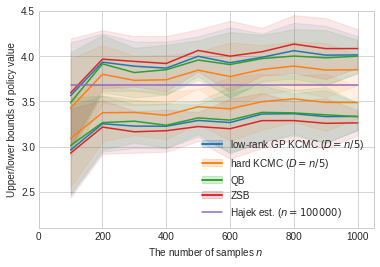

In [82]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=n / 5$)", "hard KCMC ($D=n / 5$)", "QB", "ZSB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, n)]['upper_bound'] for n in grid_sample_size])
    lower = np.array([values_mean.loc[(method_name, n)]['lower_bound'] for n in grid_sample_size])
    dupper = np.array([values_std.loc[(method_name, n)]['upper_bound'] for n in grid_sample_size])
    dlower = np.array([values_std.loc[(method_name, n)]['lower_bound'] for n in grid_sample_size])
    c = colors[method_name]
    upper_line = plt.plot(grid_sample_size, upper, c=c)[0]
    lower_line = plt.plot(grid_sample_size, lower, c=c)[0]
    upper_band = plt.fill_between(grid_sample_size, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_sample_size, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

c = tab10((0.5 + 4) / 10)
gt_line = plt.plot(grid_sample_size, [ground_truth for _ in grid_sample_size], c=c)[0]
legend_targets.append(gt_line)
legend_tags.append(r"Hajek est. ($n=100000$)")

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"The number of samples $n$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([0, 1050])
plt.ylim([2.1, 4.5])
plt.savefig('logs/policy_evaluation_synthetic_binary_changing_sample_size.pdf')

#### The interpretation of the above plot:
- Since the upper/lower bound's tightness is independent of the sample size by definition, the width of interval should not change significantly for different sample size
- However, the 

# Continuous Synthetic Data

In [5]:
from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

In [6]:
def wrap_continuous_policy(policy):
    def wrapped_policy(X, T=None, return_sample=False, requires_grad=False): 
        policy_dist = policy(X)
        if return_sample:
            return policy_dist.rsample() if requires_grad else policy_dist.sample()
        else:
            return torch.exp(policy_dist.log_prob(torch.as_tensor(T)))
    return wrapped_policy

beta_e_x = np.asarray([0, .75, -.5, 0, -1])

@wrap_continuous_policy
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    mu_t = torch.exp(z) / (1 + torch.exp(z))
    a, b = 3 * mu_t + 1, 3 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

### Experiment of changing sensitivity parameter $\Lambda$ 

def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        lr_box_const=True,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        lr_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        lr_box_const=True,
        quantile_const=True,
    ),
}

grid_lambd = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [ ]:
log_file='logs/policy_evaluation_synthetic_continuous_changing_lambda.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_lambd))
for method_name, params in grid_methods.items():
    for lambd in grid_lambd:
        params['lambd'] = lambd
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic continuous', 
            n_seeds=10, sample_size=500, log_info=method_name
        )
        pbar.update(1)
pbar.close()

In [50]:
df = pd.read_csv('logs/policy_evaluation_synthetic_continuous_changing_lambda.csv')

In [51]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,GP_KCMC,synthetic continuous,wrapped_policy,500,0,4.523167,4.616288,100,1.01,0.01,...,False,False,total variation,False,True,False,False,False,True,False
1,GP_KCMC,synthetic continuous,wrapped_policy,500,1,3.822904,3.902117,100,1.01,0.01,...,False,False,total variation,False,True,False,False,False,True,False
2,GP_KCMC,synthetic continuous,wrapped_policy,500,2,4.123222,4.208213,100,1.01,0.01,...,False,False,total variation,False,True,False,False,False,True,False
3,GP_KCMC,synthetic continuous,wrapped_policy,500,3,4.028297,4.112209,100,1.01,0.01,...,False,False,total variation,False,True,False,False,False,True,False
4,GP_KCMC,synthetic continuous,wrapped_policy,500,4,4.108444,4.193695,100,1.01,0.01,...,False,False,total variation,False,True,False,False,False,True,False


In [53]:
# due to the numerical rounding, some of the original values are invalid indices
grid_lambd = df.lambd.unique()  

In [54]:
df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1586525/1363206736.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']


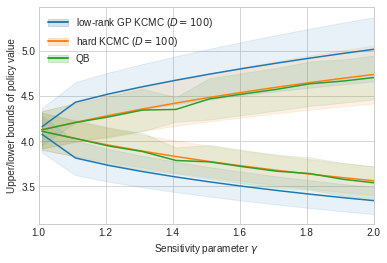

In [59]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    lower = np.array([values_mean.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    dupper = np.array([values_std.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    dlower = np.array([values_std.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    c = colors[method_name]
    upper_line = plt.plot(grid_lambd, upper, c=c)[0]
    lower_line = plt.plot(grid_lambd, lower, c=c)[0]
    upper_band = plt.fill_between(grid_lambd, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_lambd, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.savefig('logs/policy_evaluation_synthetic_continuous_changing_lambda.pdf')

# Real Data

In [1]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [3]:
from tqdm.auto import tqdm

In [4]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

#from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

In [5]:
from kcmc.data_real import generate_data, estimate_p_t

Y, T, X = generate_data()
p_t = estimate_p_t(X, T)

def LR_policy(X, T, beta):
    n = X.shape[0]
    T = torch.as_tensor(T)
    X = np.concatenate([np.ones([n, 1]), X], axis=1)
    p = torch.sigmoid(torch.tensor(X) @ beta)
    return (1 - T) * p + T * (1 - p)

beta_ipw = torch.zeros(9, requires_grad=True, dtype=float)
ipw_policy = lambda X, T: LR_policy(X, T, beta_ipw)
#ipw(Y, T ,X, p_t, ipw_policy)

train_steps = 101
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_ipw])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = ipw(Y, T, X, p_t, ipw_policy)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

toy_policy = ipw_policy

  0%|          | 0/101 [00:00<?, ?it/s]

In [6]:
def ate_policy(X, T):
    return torch.as_tensor(np.where(T == 1, 1., -1.))

In [7]:
# Guessing kernel with approximate solution
est, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, ate_policy, lambd=1.5,
    hajek_const=True, tan_box_const=True, 
    return_w=True, normalize_p_t=True, 
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2
sigma2 = gp_kernel.k1.noise_level

In [8]:
est

tensor(0.0986, dtype=torch.float64)

In [9]:
from kcmc.fast_quantile_regressor import QuantileRegressor
m = QuantileRegressor(0.2).fit(X, Y.data.numpy())
(Y.data.numpy() - m.predict(X) > 0).mean()

0.823088455772114

### Experiment of changing sensitivity parameter $\Lambda$ 

In [10]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        sigma2=sigma2 / 4,
        kernel_const=True,
        D=50,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=50,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        quantile_const=True,
        regressor_const=True,
    ),
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
}

grid_lambd = [1.0 + 0.01 + 0.1 * i for i in range(11)]

In [11]:
log_file='logs/policy_evaluation_real_binary_changing_lambda.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_lambd))
for method_name, params in grid_methods.items():
    for lambd in grid_lambd:
        params['lambd'] = lambd
        run_policy_evaluation_experiment(
            log_file, params, ate_policy, data_type='real binary', 
            n_seeds=1, sample_size=1000, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/44 [00:00<?, ?it/s]

In [12]:
df = pd.read_csv('logs/policy_evaluation_real_binary_changing_lambda.csv')

In [13]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,GP_KCMC,real binary,ate_policy,667,0,0.223965,0.230142,50,1.01,0.01,...,False,True,total variation,True,True,False,False,True,False,False
1,GP_KCMC,real binary,ate_policy,667,0,0.194506,0.259271,50,1.11,0.01,...,False,True,total variation,True,True,False,False,True,False,False
2,GP_KCMC,real binary,ate_policy,667,0,0.171056,0.282348,50,1.21,0.01,...,False,True,total variation,True,True,False,False,True,False,False
3,GP_KCMC,real binary,ate_policy,667,0,0.151957,0.300862,50,1.31,0.01,...,False,True,total variation,True,True,False,False,True,False,False
4,GP_KCMC,real binary,ate_policy,667,0,0.134629,0.317654,50,1.41,0.01,...,False,True,total variation,True,True,False,False,True,False,False


In [14]:
# due to the numerical rounding, some of the original values are invalid indices
grid_lambd = df.lambd.unique()  

In [15]:
df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1674394/1363206736.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'lambd'])['lower_bound', 'upper_bound']


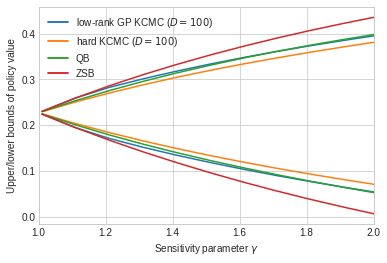

In [16]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB", "ZSB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    lower = np.array([values_mean.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    dupper = np.array([values_std.loc[(method_name, lambd)]['upper_bound'] for lambd in grid_lambd])
    dlower = np.array([values_std.loc[(method_name, lambd)]['lower_bound'] for lambd in grid_lambd])
    c = colors[method_name]
    upper_line = plt.plot(grid_lambd, upper, c=c)[0]
    lower_line = plt.plot(grid_lambd, lower, c=c)[0]
    legend_targets.append((upper_line, lower_line))

plt.legend(legend_targets, legend_tags, loc='upper left')
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([1.0, 2.0])
plt.savefig('logs/policy_evaluation_real_binary_changing_lambda.pdf')